In [11]:
# Evaluate the ML model

import tensorflow as tf
from tensorflow import keras
import os
import glob
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib as mpl
from utils import plot_loss, encoder_files_to_tensors
from utils import load_model_data_new, unnormalize_params, assess_decoder
from models import extendedCED, mse_loss_encoder, mse_loss_decoder


In [3]:
# Initialize parameters
data_dir = '/eos/kiliakis/tomo_data/datasets'

# Initialize train/ test / validation paths
ML_dir = os.path.join(data_dir, 'ML_data')
TESTING_PATH = os.path.join(ML_dir, 'TESTING')
VALIDATION_PATH = os.path.join(ML_dir, 'VALIDATION')

assert os.path.exists(TESTING_PATH)
assert os.path.exists(VALIDATION_PATH)

# Create the datasets
# First the training data
files = glob.glob(TESTING_PATH + '/*.pk')

# Shuffle them
np.random.shuffle(files)
# read input, divide in features/ label, create tensors
x_test, y_test = encoder_files_to_tensors(files)

# Then the validation data
files = glob.glob(VALIDATION_PATH + '/*.pk')

# Shuffle them
np.random.shuffle(files)
# read input, divide in features/ label, create tensors
x_valid, y_valid = encoder_files_to_tensors(files)


2022-09-15 13:08:56.245007: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/lib:/usr/lib/x86_64-linux-gnu
2022-09-15 13:08:56.245597: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-15 13:08:56.246232: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sy153): /proc/driver/nvidia/version does not exist
2022-09-15 13:08:56.253173: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Model to load
timestamp = '2022_09_15_13-04-42'

# Initialize directories
trial_dir = os.path.join('./trials/', timestamp)
weights_dir = os.path.join(trial_dir, 'weights')
plots_dir = os.path.join(trial_dir, 'plots')
assert os.path.exists(weights_dir)
os.makedirs(plots_dir, exist_ok=True)

# load the model
encoder = keras.models.load_model(os.path.join(weights_dir, 'encoder'))


In [15]:

# Evaluate the model on the test and validation data

test_loss = encoder.evaluate(x_test, y_test)
valid_loss = encoder.evaluate(x_valid, y_valid)
print(f'Test loss: {test_loss:.3f}, Valid loss: {valid_loss:.3f}')

# get predictions
test_pred = encoder.predict(x_test, verbose=False)
valid_pred = encoder.predict(x_valid, verbose=False)

# Calculate error per variable
mses = mean_squared_error(y_test, test_pred, multioutput='raw_values')


37/37 [==============================] - 1s 14ms/step - loss: 0.1341
Test loss: 0.140, Valid loss: 0.134
Variable	MSE
phase_error: 0.0045
energy_error: 0.0058
bunch_length: 0.0150
intensity: 0.8354
V_rf: 0.0068
mu: 0.0653
Vrf_SPS: 0.0475


In [16]:
var_names = ['phase_error', 'energy_error',
             'bunch_length', 'intensity', 'V_rf', 'mu', 'Vrf_SPS']
# report
print('Variable\tMSE')
for name, mse in zip(var_names, mses):
    print(f'{name}:\t{mse:.4f}')


Variable	MSE
phase_error:	0.0045
energy_error:	0.0058
bunch_length:	0.0150
intensity:	0.8354
V_rf:	0.0068
mu:	0.0653
Vrf_SPS:	0.0475


phase_error [9.72563177e-01 2.59927798e-02 0.00000000e+00 7.22021661e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.22021661e-04]
energy_error [9.24187726e-01 5.12635379e-02 1.51624549e-02 4.33212996e-03
 2.16606498e-03 7.22021661e-04 7.22021661e-04 0.00000000e+00
 0.00000000e+00 1.44404332e-03]
bunch_length [7.63898917e-01 1.50180505e-01 4.76534296e-02 2.09386282e-02
 8.66425993e-03 4.33212996e-03 2.88808664e-03 7.22021661e-04
 0.00000000e+00 7.22021661e-04]
intensity [0.65126354 0.20649819 0.08375451 0.033213   0.01371841 0.00722022
 0.00072202 0.00144404 0.00072202 0.00144404]
V_rf [0.78483755 0.12202166 0.04404332 0.02166065 0.0101083  0.00577617
 0.00433213 0.00216606 0.00361011 0.00144404]
mu [9.68953069e-01 2.31046931e-02 4.33212996e-03 7.22021661e-04
 1.44404332e-03 7.22021661e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.22021661e-04]
Vrf_SPS [7.95667870e-01 1.17689531e-01 4.33212996e-02 2.23826715e-02
 8.66425993e-03 4.33212996e-03 2.

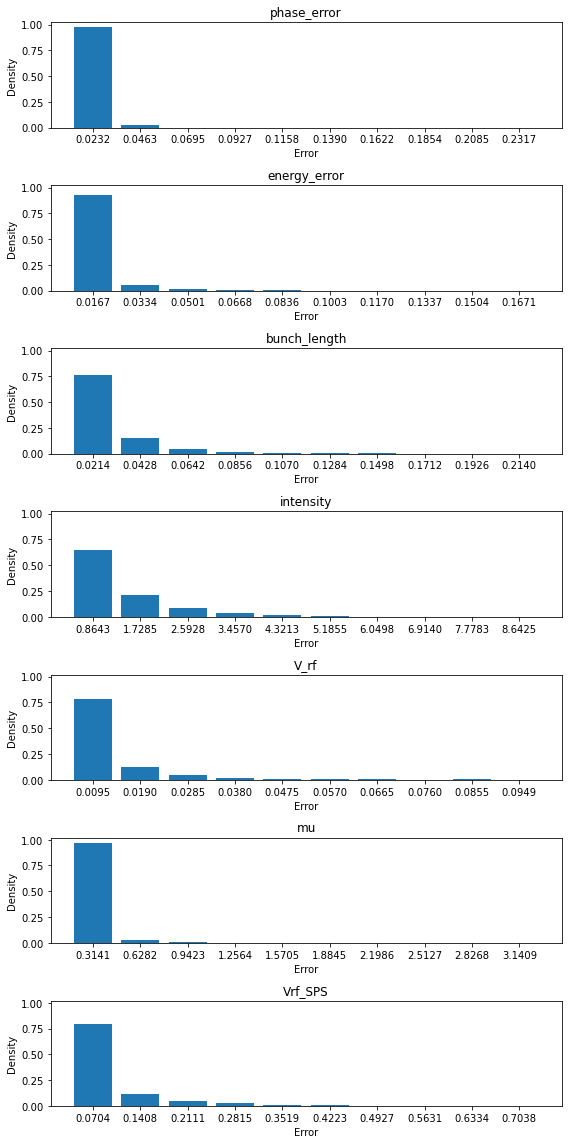

In [56]:
# Also generate MSE histogram
# print(valid_pred.shape)
square_errors = ((y_test - test_pred) * (y_test - test_pred)).numpy()

fig, axes = plt.subplots(ncols=1, nrows=len(var_names), sharex=False, 
sharey=True, figsize=(8, 16))
for i, name in enumerate(var_names):
    hist,edges = np.histogram(square_errors[:, i], bins=10, density=False)
    hist = hist / len(square_errors[:, i])
    print(name, hist)
    ax = axes[i]
    plt.sca(ax)
    plt.bar(np.arange(len(hist)), hist, width=0.8)
    plt.title(name)
    edges = [f'{e:.4f}' for e in edges]
    plt.xticks(np.arange(len(hist)), edges[1:])
    plt.xlabel('Error')
    plt.ylabel('Density')
    plt.tight_layout()


In [26]:
mses.numpy().mean()

0.14006062